# 🌍 ERA5 Weather Forecasting with Deep Learning
This notebook walks through downloading ERA5 data, processing it, and training an LSTM model for 2-3 day weather prediction.

In [3]:
# ✅ Step 1: Install required libraries
!pip install netcdf4


## ✅ Step 2: Set up CDS API (only once, then save in `~/.cdsapirc`)
Refer to: https://cds.climate.copernicus.eu/api-how-to

## ✅ Step 4: Read the downloaded NetCDF file

In [4]:
# ✅ Step 3: Download ERA5 data for 2m temperature
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'variable': '2m_temperature',
        'year': '2022',
        'month': ['01', '02', '03'],
        'day': [
            '01', '02', '03', '04', '05', '06', '07'
        ],
        'time': ['00:00', '06:00', '12:00', '18:00'],
        'format': 'netcdf',
        'area': [52.6, 13.3, 52.4, 13.5],  # Berlin
    },
    'berlin_temp_2022.nc')

2025-05-28 12:30:58,057 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-28 12:30:58,059 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-05-28 12:30:58,584 INFO Request ID is 2f1585b7-06f2-4566-8498-ba77a6ae2d28
2025-05-28 12:30:58,679 INFO status has been updated to accepted
2025-05-28 12:31:20,191 INFO status has been updated to running
2025-05-28 12:31:31,673 INFO status has been updated to successful


ecaf0d3defd19d5c9e7a3223a2b593c2.nc:   0%|          | 0.00/25.3k [00:00<?, ?B/s]

'berlin_temp_2022.nc'

In [5]:
import xarray as xr

ds = xr.open_dataset("/Users/muhammadzaki/berlin_temp_2022.nc", engine="netcdf4")
print(ds)



<xarray.Dataset>
Dimensions:     (valid_time: 84, latitude: 1, longitude: 1)
Coordinates:
    number      int64 ...
  * valid_time  (valid_time) datetime64[ns] 2022-01-01 ... 2022-03-07T18:00:00
  * latitude    (latitude) float64 52.4
  * longitude   (longitude) float64 13.3
    expver      (valid_time) object ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-27T11:19 GRIB to CDM+CF via cfgrib-0.9.1...


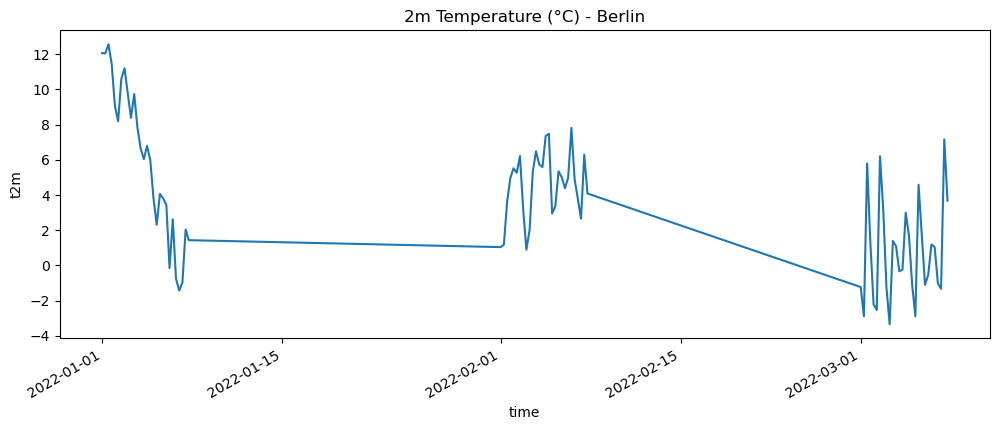

In [6]:
import xarray as xr
import matplotlib.pyplot as plt

ds = xr.open_dataset('berlin_temp_2022.nc')
temperature = ds['t2m'] - 273.15  # Kelvin to Celsius
temperature.plot(figsize=(12, 4))
plt.title('2m Temperature (°C) - Berlin')
plt.show()

## ✅ Step 5: Prepare data for LSTM model

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df = temperature.to_dataframe().reset_index()
df = df[['valid_time', 't2m']].rename(columns={'time': 'date', 't2m': 'temperature'})
df['temperature'] = df['temperature'].astype('float32')

# Normalize
scaler = MinMaxScaler()
df['scaled_temp'] = scaler.fit_transform(df[['temperature']])

## ✅ Step 6: Create sequences for LSTM (3 steps lookback to predict next 1)

In [8]:
def create_sequences(data, window_size=3):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X, y = create_sequences(df['scaled_temp'].values)

## ✅ Step 7: Train LSTM Model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential([
    LSTM(64, input_shape=(X.shape[1], 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=10, batch_size=16)

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1940  
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1096
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0826
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0477
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0331
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0289
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0310
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0269
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0298
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0316


## ✅ Step 8: Predict next 3 days

In [10]:
# Predict 3 steps ahead
last_seq = df['scaled_temp'].values[-3:].tolist()
preds = []
for _ in range(3):
    input_seq = np.array(last_seq[-3:]).reshape((1, 3, 1))
    next_val = model.predict(input_seq)[0][0]
    preds.append(next_val)
    last_seq.append(next_val)

# Inverse scale
preds_actual = scaler.inverse_transform(np.array(preds).reshape(-1, 1))
print('Predicted Temperatures (next 3 days):', preds_actual.flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Predicted Temperatures (next 3 days): [3.0824604 4.186518  3.4650743]
